### First add the data functions to the path

In [1]:
import sys
import numpy as np
import pandas as pd
import xarray as xr
import copy
import seaborn as sns
from netCDF4 import Dataset
from pathlib import Path
from datetime import datetime, timedelta
notebook_dir = !pwd # Replace with !echo %cd% if using windows
library_dir = Path(notebook_dir[0]).parent.absolute()
sys.path.append(str(library_dir))
data_raw_path = library_dir / 'data' / 'raw' / 'adcp'
glider_raw_path = library_dir / 'data' / 'raw' / 'glider'
fig_path = library_dir / 'reports' / 'figures'
from src.data.adcp_mission_analysis import adcp_import_data, add_dive_averages, read_glider_nc, edgetocentre, savefig
#from src.data.beam_mapping import beam2enu, beam_from_center, caltran

Use better plotting defaults

In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
style_path = library_dir / 'src' / 'visualization' / 'presentation.mplstyle'
style.use(str(style_path))

### Load the data into Python

In [ ]:
overview, mission_dict = adcp_import_data(data_raw_path)


Add beam attributes. These are taken from the fifth cell (11.3 m from the glider on default settings) and averaged over each ascent/descent profile

In [ ]:
beam_attrs, adcp_df = add_dive_averages(overview, mission_dict)
beam_attrs
# overview.join(beam_attrs)

In [ ]:
adcp_df.head()

Check that the data start when you expect. The first file in particular may have data from a previous sim dive or bench test. adapt the following cell to select the data starting on the correct day

In [ ]:
# For this dataset, need to remove the data before 23 Jan they are from 2019 benchtests and 2020 sim dives
adcp_df = adcp_df['2020-01-23':]

In [ ]:
beam_attrs.plot(subplots=True,figsize=(20,40),marker='o');
savefig('beam_attributes')

In [ ]:
len(np.arange(0,len(beam_attrs.index), 0.5)

### Print some key QC parameters from each dive limb

In [ ]:
fig, ax = plt.subplots(5,1, sharex=True, figsize=(14,15))
ax = ax.ravel()
ax[0].scatter(np.arange(0,len(beam_attrs.index)/2,0.5), beam_attrs.cor_beam_1, label='correlation (%)')
ax[1].scatter(np.arange(0,len(beam_attrs.index)/2,0.5), beam_attrs.amp_beam_1, label='return amp (dB)')
ax[2].scatter(np.arange(0,len(beam_attrs.index)/2,0.5), np.abs(beam_attrs.pitch), label='|pitch|')
ax[3].scatter(np.arange(0,len(beam_attrs.index)/2,0.5), beam_attrs.roll, label='|roll|')
ax[3].set(ylim = [0,15])
ax[4].scatter(np.arange(0,len(beam_attrs.index)/2,0.5), beam_attrs.beam_miss, label='Beam miss (m)')
ax[4].set(ylim = [0,2])
for axi in ax:
    axi.legend()
savefig('beam_attrs_short')

See which variables are correlated between the dive limbs

In [ ]:
attr_corr = beam_attrs.corr()
mask = np.triu(np.ones_like(attr_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 22))
sns.heatmap(attr_corr, cmap='RdBu_r', vmin=-1,vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Load in glider attitude data for comparison with that from the ADCP

In [4]:
glider_df = read_glider_nc(glider_raw_path / 'sg637_full_timeseries.nc')
glider_df

,DAC_u,DAC_v,abs_salinity,conductivity,cons_temp,depth,direction,dive,dive_num,lat,...,rho,salinity,salinity_nocorr,sigma0,temp,roll,pitch,heading,w_H2O,glider_time
2020-01-23 14:35:40.870005,-0.084725,0.065625,35.601190,55.756318,26.966234,1.340919,-1.0,1.0,1.0,14.183558,...,1023.058349,35.433673,35.433673,1023.052657,26.980132,10.5,-50.6,97.6,-0.001678,2020-01-23 14:35:40.870005
2020-01-23 14:35:46.834999,-0.084725,0.065625,35.601343,55.761965,26.971450,1.350925,-1.0,1.0,1.0,14.183558,...,1023.056837,35.433825,35.429688,1023.051102,26.985348,1.4,-55.2,128.8,-0.005775,2020-01-23 14:35:46.834999
2020-01-23 14:35:54.732995,-0.084725,0.065625,35.605989,55.759010,26.962315,1.420973,-1.0,1.0,1.0,14.183558,...,1023.063478,35.438449,35.436477,1023.057446,26.976428,5.5,-60.7,117.6,-0.014122,2020-01-23 14:35:54.732995
2020-01-23 14:36:01.007001,-0.084725,0.065625,35.601852,55.760088,26.968771,1.551062,-1.0,1.0,1.0,14.183558,...,1023.058918,35.434331,35.433727,1023.052334,26.982740,-4.3,-64.2,128.3,-0.003273,2020-01-23 14:36:01.007001
2020-01-23 14:36:06.963999,-0.084725,0.065625,35.612017,55.772225,26.966604,1.461000,-1.0,1.0,1.0,14.183558,...,1023.066718,35.444448,35.442142,1023.060517,26.980960,11.2,-66.4,120.9,0.004194,2020-01-23 14:36:06.963999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-16 13:58:34.845004,-0.052225,0.004649,35.711597,55.535589,26.609093,4.433003,1.0,155.0,155.0,14.182904,...,1023.266628,35.543544,35.544124,1023.247793,26.628579,-6.3,37.0,209.2,0.019803,2020-02-16 13:58:34.845004
2020-02-16 13:58:39.844001,-0.052225,0.004649,35.712441,55.538799,26.611685,3.322260,1.0,155.0,155.0,14.182895,...,1023.261708,35.544389,35.544758,1023.247593,26.630946,-8.9,36.5,219.3,0.043055,2020-02-16 13:58:39.844001
2020-02-16 13:58:44.847001,-0.052225,0.004649,35.712781,55.540981,26.614227,1.861273,1.0,155.0,155.0,14.182887,...,1023.254946,35.544736,35.544210,1023.247038,26.633164,0.0,23.2,227.3,0.072271,2020-02-16 13:58:44.847001
2020-02-16 13:58:49.845003,-0.052225,0.004649,35.709926,55.538544,26.616121,1.290884,1.0,155.0,155.0,14.182883,...,1023.249816,35.541897,35.541011,1023.244331,26.634813,-8.5,6.1,234.2,0.064037,2020-02-16 13:58:49.845003


In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(glider_df.index, glider_df.pressure, label='glider', s=1)
ax.scatter(adcp_df.index, adcp_df.pressure_ad, label='adcp', s=1)
ax.set(xlim=[datetime(2020,1,24,0), datetime(2020,1,24,12)],ylim = [-10,750], ylabel='Pressure (dbar)')
ax.legend()
savefig('pressure_glider_vs_adcp')

### Attitude comparison. A mismatch may indicate physcal misalignment of the glider and ADCP or a poor calibration of the accelerometers in either unit.

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(20,26), sharex=True)
ax = ax.ravel()
ax[0].scatter(glider_df.index, glider_df.pitch, label='glider')
ax[0].scatter(adcp_df.index, adcp_df.pitch_ad, label='adcp')
ax[0].set(xlim=[datetime(2020,1,24,0), datetime(2020,1,24,12)], ylim=[-30,30], ylabel='Pitch')
ax[1].scatter(glider_df.index, glider_df.roll)
ax[1].scatter(adcp_df.index, adcp_df.roll_ad)
ax[1].set(ylim=[-20,20], ylabel='Roll')
ax[2].scatter(glider_df.index, glider_df.heading)
ax[2].scatter(adcp_df.index, adcp_df.heading_ad)
ax[2].set(ylim=[50,200], ylabel='Heading')
ax[0].legend();
savefig('attitude_glider_vs_adcp')

In [18]:
glider_av_df = glider_df.groupby('dive', as_index=False).mean()
glider_av_df

,dive,DAC_u,DAC_v,abs_salinity,conductivity,cons_temp,depth,direction,dive_num,lat,...,profile_num,rho,salinity,salinity_nocorr,sigma0,temp,roll,pitch,heading,w_H2O
0,1.0,-0.084725,0.065625,35.788506,56.160908,27.072773,33.255417,0.011236,1.0,14.183564,...,1.505618,1023.297432,35.620152,35.619861,1023.156442,27.101444,1.566292,-1.967416,134.550000,0.028042
1,2.0,-0.027886,0.048223,36.331715,56.833781,26.966266,53.898726,-0.003155,2.0,14.184404,...,3.498423,1023.818319,36.120480,36.162095,1023.589964,27.021306,0.399685,-0.372871,129.073817,0.019832
2,3.0,0.019825,0.040436,36.778769,52.646258,22.459501,133.839393,-0.193585,3.0,14.184532,...,5.403207,1025.794569,36.618923,36.586501,1025.216115,22.542531,-0.081672,-0.825659,138.452234,0.012452
3,4.0,0.030359,0.042735,36.777865,52.804262,22.612847,131.485829,-0.171717,4.0,14.181947,...,7.414141,1025.741053,36.607575,36.585004,1025.173038,22.695500,-0.216723,-0.356453,142.740516,0.011825
4,5.0,-0.080348,0.087104,35.999617,45.054329,15.792681,281.282805,-0.326414,5.0,14.190570,...,9.336793,1027.495478,35.829191,35.829509,1026.239128,15.864827,-0.309964,-1.652050,300.519564,0.006344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,151.0,-0.046879,0.051728,36.326764,55.978509,26.275013,56.721289,0.215827,151.0,14.181836,...,301.607914,1023.998873,36.155907,36.090675,1023.757920,26.327814,0.293525,1.868345,143.435252,0.016740
151,152.0,-0.043818,0.066245,36.304310,55.902495,26.217850,56.198868,0.208791,152.0,14.181038,...,303.604396,1024.007212,36.140944,36.081682,1023.768399,26.270034,-0.075458,1.900733,139.268132,0.021857
152,153.0,-0.034167,0.094024,36.282977,56.001032,26.265209,55.731900,0.213235,153.0,14.181103,...,305.606618,1024.013115,36.112326,36.112418,1023.776336,26.318556,1.999265,2.547059,110.813235,0.025878
153,154.0,-0.130354,0.113996,36.259643,55.894545,26.273623,55.570657,0.200000,154.0,14.183252,...,307.600000,1023.951384,36.094793,36.032169,1023.715289,26.323838,0.276400,2.684800,47.927600,0.027976


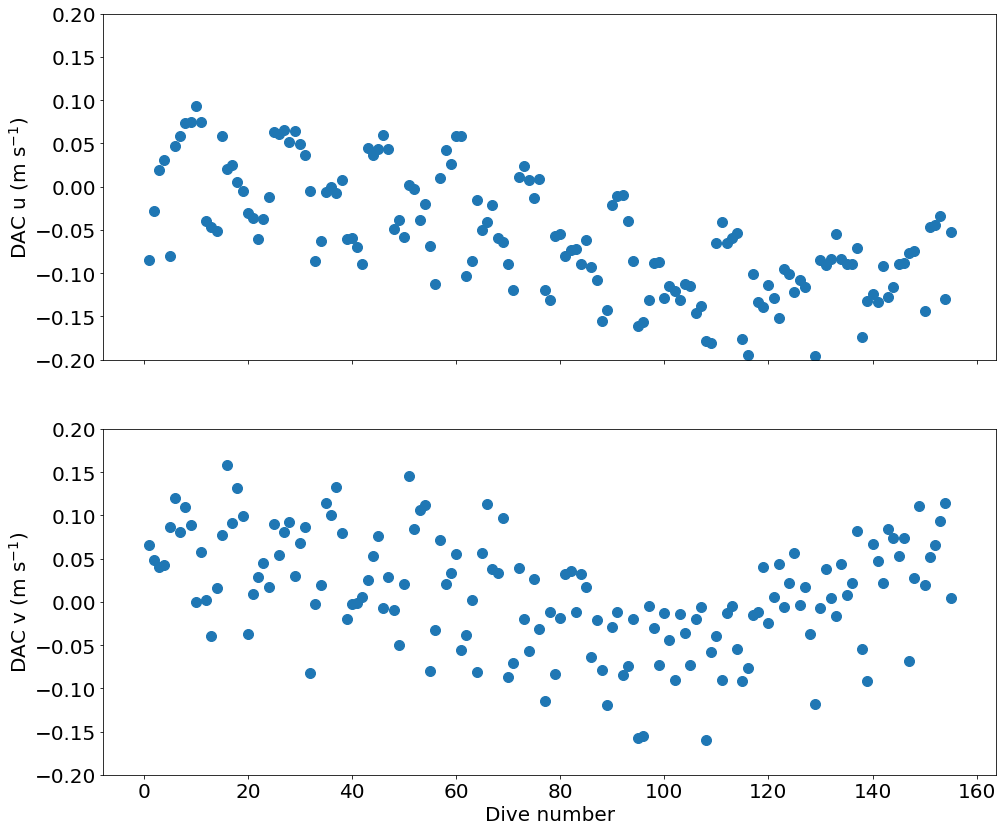

In [31]:
fig, ax = plt.subplots(2,1,figsize=(16,14), sharex=True)
ax = ax.ravel()
ax[0].scatter(glider_av_df.dive_num, glider_av_df.DAC_u)
ax[1].scatter(glider_av_df.dive_num, glider_av_df.DAC_v)
ax[0].set(ylabel='DAC u $(\mathrm{m\ s^{-1}})$', ylim=[-0.2, 0.2])
ax[1].set(ylabel='DAC v $(\mathrm{m\ s^{-1}})$', xlabel='Dive number', ylim=[-0.2, 0.2])
savefig('DAC_by_dive')

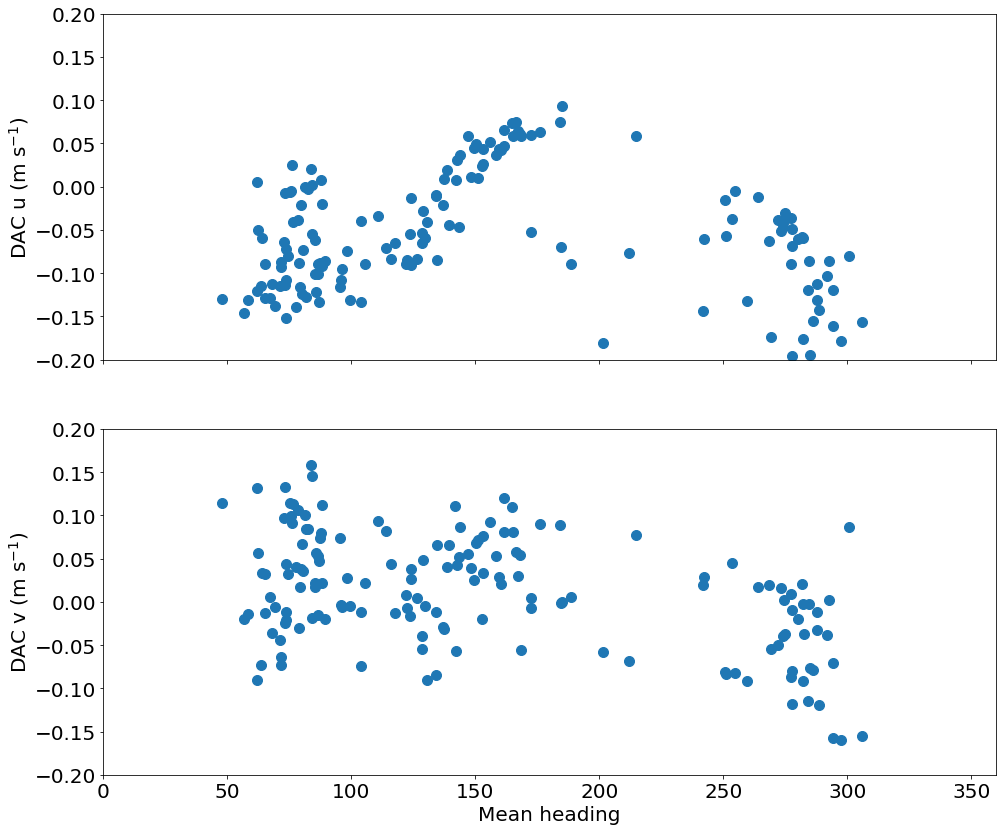

In [32]:
fig, ax = plt.subplots(2,1,figsize=(16,14), sharex=True)
ax = ax.ravel()
ax[0].scatter(glider_av_df.heading, glider_av_df.DAC_u)
ax[1].scatter(glider_av_df.heading, glider_av_df.DAC_v)
ax[0].set(ylabel='DAC u $(\mathrm{m\ s^{-1}})$', ylim=[-0.2, 0.2])
ax[1].set(ylabel='DAC v $(\mathrm{m\ s^{-1}})$', xlabel='Mean heading', ylim=[-0.2, 0.2], xlim=[0,360])
savefig('DAC_by_heading')

In [ ]:
def edgetocentre(x_in):
    x_out = np.array(x_in)
    return (np.nanmean([x_out[1:], x_out[:-1]], axis=0))

In [ ]:
dive_vel[:,1,0][:-1]

In [ ]:
def glider_vel(mission_dict, cell=1):
    asc_wp, asc_u, asc_v, asc_w, asc_dive_no = [], [], [], [], []
    des_wp, des_u, des_v, des_w, des_dive_no = [], [], [], [], []

    for item in list(mission_dict):
        print(item)
        dive = mission_dict[item]
        flagger = copy.deepcopy(dive.flag_bad_data)
        for i in range(np.size(flagger,1)):
            flagger[:,i,:] = flagger[:,3,:]
        dive_vel = copy.deepcopy(dive.vel_xyz)
        #dive_vel[flagger] = np.nan
        if item[-1] == 'a':
            des_u.append(edgetocentre(dive_vel[:,cell,0]))
            des_v.append(edgetocentre(dive_vel[:,cell,1]))
            des_w.append(edgetocentre(dive_vel[:,cell,2]))
            des_wp.append(dive.glider_w_from_p)
            dive_no = np.empty((len(dive.glider_w_from_p)))
            dive_no[:] = float(str(item)[:-1])
            des_dive_no.append(dive_no)
        else:
            asc_u.append(edgetocentre(dive_vel[:,cell,0]))
            asc_v.append(edgetocentre(dive_vel[:,cell,1]))
            asc_w.append(edgetocentre(dive_vel[:,cell,2]))
            asc_wp.append(dive.glider_w_from_p) 
            dive_no = np.empty((len(dive.glider_w_from_p)))
            dive_no[:] = float(str(item)[:-1])
            asc_dive_no.append(dive_no)
    des_df = pd.DataFrame({'dive_no':[item for sublist in des_dive_no for item in sublist], 'u':[item for sublist in des_u for item in sublist], 'v': [item for sublist in des_v for item in sublist], 'w':[item for sublist in des_w for item in sublist], 'w_from_p':[item for sublist in des_wp for item in sublist]}, index=None)
    asc_df = pd.DataFrame({'dive_no':[item for sublist in asc_dive_no for item in sublist], 'u':[item for sublist in asc_u for item in sublist], 'v': [item for sublist in asc_v for item in sublist], 'w':[item for sublist in asc_w for item in sublist], 'w_from_p':[item for sublist in asc_wp for item in sublist]}, index=None)
    return des_df, asc_df
des_df, asc_df = glider_vel(mission_dict)

In [ ]:
dive = mission_dict['0041a']
flagger = copy.deepcopy(dive.flag_bad_data)
for cell in range(np.size(flagger,1)):
    flagger[:,cell,:] = flagger[:,3,:]
dive_vel = copy.deepcopy(dive.vel_xyz)
dive_vel[:,1,0][:-1]

In [ ]:
ax[0].scatter(-foo.glider_w_from_p,foo.vel_xyz[:,1,0][:-1], label='x')

In [ ]:
dive_vel[:,cell,0]

In [ ]:
mission_dict['0041b'].flag_bad_data[:,3,:]

In [ ]:
sub_df = asc_df[asc_df.dive_no== 41.0]
sub_df.describe()

In [ ]:
des_df.describe()

In [ ]:
asc_df.describe()

In [ ]:
sub_df = asc_df[asc_df.dive_no== 41.0]
sub_df.describe()asc_df.corr()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,10), sharey=True)
ax = ax.ravel()
ax[0].scatter(-des_df.u, des_df.w_from_p, s = 0.5, label='Dive')
ax[0].scatter(-asc_df.u, asc_df.w_from_p, s = 0.5, label='Climb')
ax[0].set(xlim=[0, 0.6], ylim=[-0.3, 0.3], xlabel='Glider forward speed from ADCP', ylabel='Vertical speed from pressure')
ax[0].legend()

ax[1].scatter(-des_df.v, des_df.w_from_p, s = 0.5, label='Dive')
ax[1].scatter(-asc_df.v, asc_df.w_from_p, s = 0.5, label='Climb')
ax[1].set(xlim=[-0.2,0.2], ylim=[-0.3, 0.3], xlabel='Glider cross speed from ADCP')
savefig('all_speed_pressure')


In [ ]:
g = sns.jointplot(des_df.u, des_df.w_from_p, height=12, space=0, xlim=(-0.6, 0.0), ylim=(-0.3, -0.04))
savefig('seaborn_den_scat')

In [ ]:
g = sns.jointplot(asc_df.u, asc_df.w_from_p, kind="kde", height=12, space=0, xlim=(-1, 0.2), ylim=(0.06, 0.14))

In [ ]:
asc_df.corr()

Plot the xyz velocites from one dive cycle. Upper panel dive, lower panel climb

In [ ]:
foo = mission_dict['0061a']
bar = mission_dict['0061b']

In [ ]:
sub_df = asc_df[asc_df.dive_no== 41.0]
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(sub_df.w_from_p, sub_df.u)
#ax.set(xlim=[-0.5, 0.5], ylim=[-0.5, 0.5])

In [ ]:
sub_df

In [ ]:
dive = mission_dict['0041a']
flagger = copy.deepcopy(dive.flag_bad_data)
for cell in range(np.size(flagger,1)):
    flagger[:,cell,:] = flagger[:,3,:]
dive_vel = copy.deepcopy(dive.vel_xyz)
dive_vel[:,1,0][:-1]

In [ ]:
np.round(edgetocentre(foo.vel_xyz[:,1,0]) - des_df.u.values,2)

In [ ]:
des_df.u

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(12,14), sharex=False)
ax = ax.ravel()
ax[0].scatter(-foo.glider_w_from_p,foo.vel_xyz[:,1,0][:-1], label='x')
ax[0].scatter(-foo.glider_w_from_p,foo.vel_xyz[:,1,1][:-1], label='y')
#ax[0].scatter(-foo.glider_w_from_p,foo.vel_xyz[:,1,2][:-1], label='z')
ax[0].set(xlim=[0,0.2], ylim=[-0.4,0.4],ylabel='xyz water velocity from ADCP m/s')
ax[0].legend()
ax[1].scatter(-bar.glider_w_from_p,bar.vel_xyz[:,1,0][:-1], label='x')
ax[1].scatter(-bar.glider_w_from_p,bar.vel_xyz[:,1,1][:-1], label='y')
#ax[1].scatter(-bar.glider_w_from_p,bar.vel_xyz[:,1,2][:-1], label='z')
ax[1].set(xlim=[-0.25,0.], ylim=[-0.4,0.4], xlabel='w from pressure m/s')
#savefig('xyz_vel_dive41')

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(12,14), sharex=False)
ax = ax.ravel()
ax[0].scatter(tl, -foo.measurement_z, c=foo.cor_beam[:,:,2],  label='x')
#ax[0].scatter(-foo.glider_w_from_p,foo.vel_xyz[:,1,1][:-1], label='y')
#ax[0].scatter(-foo.glider_w_from_p,foo.vel_xyz[:,1,2][:-1], label='z')
#ax[0].set(xlim=[0,0.2], ylim=[-0.4,0.4],ylabel='xyz water velocity from ADCP m/s')
ax[0].legend()
ax[1].scatter(-bar.glider_w_from_p,bar.vel_xyz[:,1,0][:-1], label='x')
ax[1].scatter(-bar.glider_w_from_p,bar.vel_xyz[:,1,1][:-1], label='y')
#ax[1].scatter(-bar.glider_w_from_p,bar.vel_xyz[:,1,2][:-1], label='z')
ax[1].set(xlim=[-0.25,0.], ylim=[-0.4,0.4], xlabel='w from pressure m/s')
#savefig('xyz_vel_dive41')

In [ ]:
foo.cor_beam[:,:,2]
foo.measurement_z
tl = np.transpose(np.tile(foo.time, (15,1)))
tl2 = np.transpose(np.tile(bar.time, (15,1)))

In [ ]:
fig, ax = plt.subplots(figsize=(12,14))

mp0 = ax.scatter(tl, foo.measurement_z, c=foo.cor_beam[:,:,2], vmin=0, vmax=100,cmap='RdBu',s=10)
ax.scatter(tl2, bar.measurement_z, c=bar.cor_beam[:,:,2], vmin=0, vmax=100,cmap='RdBu',s=10)
fig.colorbar(ax = ax,mappable=mp0, label='Ping correlation %')
ax.set(xlim=[tl[0,0], tl2[-1,-1]], ylabel='z (m)')
savefig('correlation')

In [ ]:
fig, ax = plt.subplots(figsize=(12,14))

mp0 = ax.scatter(tl, foo.measurement_z, c=foo.beam_miss, vmin=0, vmax=2,cmap='RdBu_r',s=10)
ax.scatter(tl2, bar.measurement_z, c=bar.beam_miss, vmin=0, vmax=2,cmap='RdBu_r',s=10)
fig.colorbar(ax = ax,mappable=mp0, label='Beam miss (m)')
ax.set(xlim=[tl[0,0], tl2[-1,-1]], ylabel='z (m)')
savefig('beam_miss')

In [ ]:
foo.beam_miss

In [ ]:
np.shape(foo.measurement_z)

As above for enu velocites

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(12,14), sharex=False)
ax = ax.ravel()
ax[0].scatter(-foo.glider_w_from_p,foo.vel_enu[:,0,0][:-1], label='x')
ax[0].scatter(-foo.glider_w_from_p,foo.vel_enu[:,0,1][:-1], label='y')
#ax[0].scatter(-foo.glider_w_from_p,foo.vel_enu[:,0,2][:-1], label='z')
ax[0].set(xlim=[0,0.2], ylim=[-0.4,0.4],ylabel='water velocity from ADCP m/s')
ax[0].legend()
ax[1].scatter(-bar.glider_w_from_p,bar.vel_enu[:,0,0][:-1], label='x')
ax[1].scatter(-bar.glider_w_from_p,bar.vel_enu[:,0,1][:-1], label='y')
#ax[1].scatter(-bar.glider_w_from_p,bar.vel_enu[:,0,2][:-1], label='z')
ax[1].set(xlim=[-0.25,0.], ylim=[-0.4,0.4], xlabel='w from pressure m/s')
savefig('enu_vel_dive41')

In [ ]:
all_the_shear = np.empty((len(mission_dict),100,3))
all_the_amp = np.empty((len(mission_dict),100,3))

in_bin = np.empty((len(mission_dict), 100))
for i, dive in enumerate(mission_dict.keys()):
    all_the_shear[i,:,:] = mission_dict[dive].vel_referenced
    in_bin[i,:] = mission_dict[dive].no_in_bin
    all_the_amp[i,:] = mission_dict[dive].amp_binned


In [ ]:
np.shape(all_the_amp)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
nos = ax.pcolor(np.arange(0,len(overview.index)/2,0.5), np.arange(-1000,10,10),np.transpose(np.nanmean(all_the_amp,2)),vmin=30, vmax=40, cmap='RdBu')
ax.set(ylim=[-760,0], ylabel='z (m)', xlabel='Dive number', label='return_amp')
fig.colorbar(mappable=nos,ax=ax)
savefig('return_amp')

Check how many adcp velocity shear measurements were used in each cell of the velocity profile

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
nos = ax.pcolor(np.arange(0,len(overview.index)/2,0.5), np.arange(-1000,10,10),np.transpose(in_bin), vmin=0, vmax=100, cmap='viridis')
ax.set(ylim=[-760,0], ylabel='z (m)', xlabel='Dive number')
fig.colorbar(mappable=nos,ax=ax, label='number of shear estimates per bin', extend='max')
savefig('vels_per_10m_bin')

Plot the shear profiles

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(15,30), sharex=True)
ax = ax.ravel()
ax[0].pcolor(np.transpose(all_the_shear[201:250,:,0]), cmap='RdBu_r', vmin=-0.5, vmax=0.5)
ax[1].pcolor(np.transpose(all_the_shear[201:250,:,1]), cmap='RdBu_r', vmin=-0.5, vmax=0.5)

-------------------
# Rough stuff